In [1]:
#Loading all the packages
import json
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
import joblib
from sklearn.metrics import (precision_score, recall_score, roc_auc_score, accuracy_score,
                               confusion_matrix, precision_recall_curve, roc_curve, brier_score_loss)

In [2]:
#Load and Unzip the zip file
file = zipfile.ZipFile(r'C:\Users\SWEEKRITHI SHETTY\Downloads\transactions.zip', 'r')
zipinfos = file.infolist()
data = file.open(zipinfos[0].filename).read().splitlines()

In [3]:
#Convert the json file into a pandas dataframe
data = [json.loads(rows) for rows in data]
data = pd.DataFrame(data)

In [4]:
data

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.00,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.00,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.00,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,...,,1095.04,,,,False,,,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,...,,1214.96,,,,False,,,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,...,,1233.85,,,,False,,,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,...,,1283.28,,,,False,,,False,False


In [5]:
#Converting blank cells into NAaN
data = data.replace(r'^\s*$', np.nan, regex=True)
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [6]:
#Shape the dataset
data_shape = data.shape
print(f'This dataset includes {data_shape[0]} records and each record contains {data_shape[1]} fields.')

This dataset includes 786363 records and each record contains 29 fields.


In [7]:
#Type of each column in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  object 
 10  posConditionCode          785954 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [8]:
#Basic Summary statistics
data.describe()

,creditLimit,availableMoney,transactionAmount,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,10759.464459,6250.725369,136.985791,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,11636.174890,8880.783989,147.725569,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,250.000000,-1005.630000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5000.000000,1077.420000,33.650000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,7500.000000,3184.860000,87.900000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,15000.000000,7500.000000,191.480000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,50000.000000,50000.000000,2011.540000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


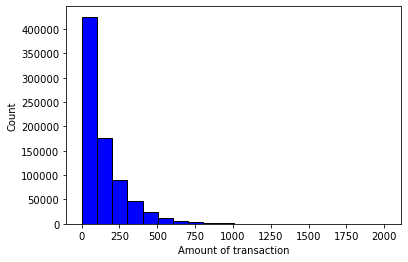

In [9]:
#Here're some outliers.So next I'll remove outliers and plot a basic histogram with remaining transaction amount
plt.hist(data['transactionAmount'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

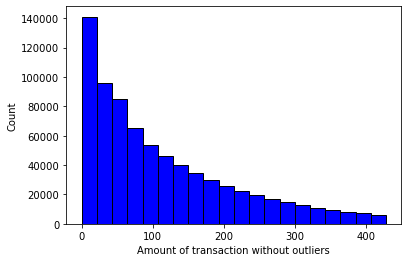

In [10]:
#transaction values should be no less than 0 so I remove values which < 0 
#According to the definition of outlier, I also remove values which are greater than Q3 + 1.5IQR
q1, q3 = np.percentile(sorted(data.transactionAmount),[25,75])
iqr = q3 - q1
lower_bound = 0
upper_bound = q3 + (1.5 * iqr)
x = data.transactionAmount[data.transactionAmount.between(lower_bound, upper_bound)]
plt.hist(x, color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction without outliers', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

C:\Users\SWEEKRITHI SHETTY\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SWEEKRITHI SHETTY\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


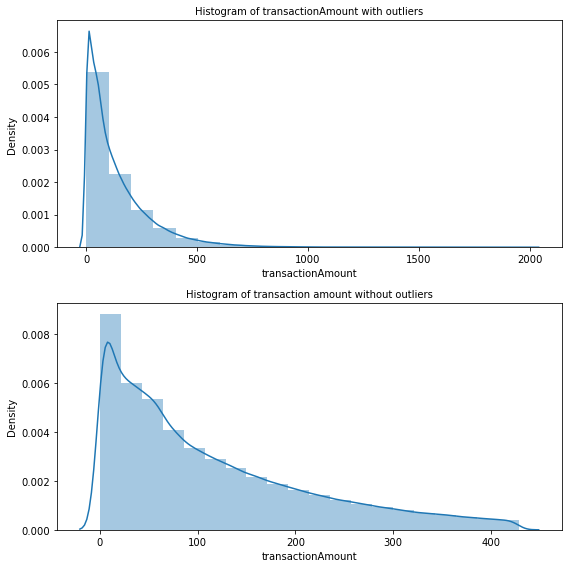

In [11]:
# A KDE plot of transactions with outlier
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.distplot(data['transactionAmount'], hist=True, bins=20, kde=True, ax=ax[0])
ax[0].set_title('Histogram of transactionAmount with outliers', fontsize=10)
#A KDE plot of transactions without outliers
sns.distplot(x, hist=True, bins=20, kde=True, ax=ax[1])
ax[1].set_title('Histogram of transaction amount without outliers', fontsize=10)
plt.tight_layout()
plt.show()

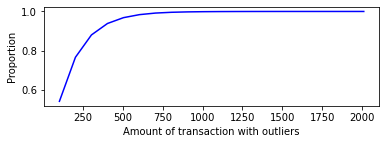

In [12]:
#Cumulative distribution plots of transaction amount
# A cumulative distribution plot of transactions with outliers
plt.subplot(2, 1, 1)
H,X1 = np.histogram(data['transactionAmount'], density=True, bins=20)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, color='blue')
plt.xlabel('Amount of transaction with outliers', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.show()

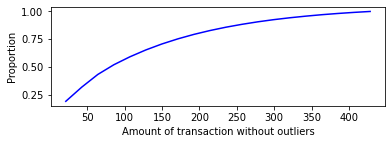

In [13]:
# A cumulative distribution plot of transactions without outliers
plt.subplot(2, 1, 2)
H,X1 = np.histogram(x, density=True, bins=20)
dx = X1[1] - X1[0] 
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, color='blue')
plt.xlabel('Amount of transaction without outliers', fontsize=10)
plt.ylabel('Proportion', fontsize=10) 
plt.show()

In [14]:
#From the histograms above, we can see that the distribuion of transaction amount is severely right-skewed
#So I hypothesize that the amount of a valid transaction is highly possible to lie between 0 to 500. And from the cumulative distribution plots,we can say that half of transactions will be less than 100

In [15]:
#Data Wrangling - Duplicate Transactions

In [16]:
#The criteria for a reversed transaction is that a purchase should be followed by a reversal, which indicates that
#1. one purchase should have a corrsponding one reversal
#2. the transactionDateTime of the purchase should be earlier than the reversal

In [17]:
#With these 2 criteria, to filter all reversed transactions:
#1. selecting duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' to find transactions of same amount within the same account from the same merchant, which are possible to be reversed transactions
#2. creating 2 seperate datasets pur_tran and rev_tran from the duplicated dataset, one containing all purchasing records from the duplicated dataset and the other containing all reversal records from the duplicated dataset
#3. inner joining 2 datasets by 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', which means that for every record in the purchasing dataset, if there's a record in the reversal dataset which has the same values in 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', this 2 records will be merged into a new dataset. In the new dataset, features with suffix_x refers to the features from the original purchasing data, features with suffix_y refers to variables from the reversal data
#4. selecting rows which its purchasing transaction DateTime is earlier than its reversal transaction DateTime.

In [18]:
#Convert time columns to standard format
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'], infer_datetime_format=True) 
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'], infer_datetime_format=True)
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'], infer_datetime_format=True)
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'], infer_datetime_format=True)

In [19]:
#Select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName'
duplicated = data[data.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]

In [20]:
duplicated

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
11,830329091,830329091,5000.0,5000.00,2016-12-07 16:34:04,40.75,GreenCook,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
12,830329091,830329091,5000.0,4959.25,2016-12-14 10:00:35,40.75,GreenCook,US,US,09,...,NaN,40.75,NaN,NaN,NaN,False,NaN,NaN,False,False
13,830329091,830329091,5000.0,4918.50,2016-12-20 18:38:23,40.75,GreenCook,US,US,09,...,NaN,81.50,NaN,NaN,NaN,False,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786346,732852505,732852505,50000.0,49536.24,2016-11-22 19:30:16,51.48,Sunoco Gas #380975,US,US,05,...,NaN,463.76,NaN,NaN,NaN,True,NaN,NaN,False,False
786348,732852505,732852505,50000.0,49251.72,2016-11-25 13:39:10,18.89,hulu.com,US,US,09,...,NaN,748.28,NaN,NaN,NaN,False,NaN,NaN,False,False
786352,732852505,732852505,50000.0,49848.35,2016-12-07 14:05:14,51.48,Sunoco Gas #380975,US,US,05,...,NaN,151.65,NaN,NaN,NaN,True,NaN,NaN,False,False
786357,732852505,732852505,50000.0,48956.44,2016-12-22 07:27:23,51.48,Sunoco Gas #380975,US,US,05,...,NaN,1043.56,NaN,NaN,NaN,True,NaN,NaN,False,False


In [21]:
# Get all records whose transaction type is reversal from the duplicated data
pur_tran = duplicated[duplicated.transactionType == 'PURCHASE']
rev_tran = duplicated[duplicated.transactionType == 'REVERSAL']

In [22]:
# Inner joined the 2 datasets by 'accountNumber', 'customerId', 'transactionAmount', 'merchantName'
reversed_trans = pd.merge(pur_tran, rev_tran, on=['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], how='inner')
reversed_trans.head()

,accountNumber,customerId,creditLimit_x,availableMoney_x,transactionDateTime_x,transactionAmount,merchantName,acqCountry_x,merchantCountryCode_x,posEntryMode_x,...,echoBuffer_y,currentBalance_y,merchantCity_y,merchantState_y,merchantZip_y,cardPresent_y,posOnPremises_y,recurringAuthInd_y,expirationDateKeyInMatch_y,isFraud_y
0,574788567,574788567,2500.0,2416.11,2016-05-24 01:35:33,215.13,Convenient Tire,US,US,09,...,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
1,924729945,924729945,50000.0,50000.00,2016-10-04 04:20:04,168.57,discount.com,US,US,05,...,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
2,984504651,984504651,50000.0,49138.85,2016-01-06 04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,...,NaN,11909.30,NaN,NaN,NaN,True,NaN,NaN,False,False
3,984504651,984504651,50000.0,46818.15,2016-01-16 09:52:30,450.74,Planet Fitness #849960,US,US,05,...,NaN,3632.59,NaN,NaN,NaN,False,NaN,NaN,False,False
4,984504651,984504651,50000.0,46341.05,2016-01-17 08:13:08,81.73,AMC #724446,US,US,09,...,NaN,8090.70,NaN,NaN,NaN,True,NaN,NaN,False,False


In [23]:
# Select rows which its purchasing transaction DateTime is earlier than its reversal transaction DateTime.
reversed_trans = reversed_trans[reversed_trans.transactionDateTime_x < reversed_trans.transactionDateTime_y]

In [24]:
# The final reversal transaction data
reversed_trans[['accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionDateTime_x', 'transactionDateTime_y',
               'transactionType_x', 'transactionType_y']].head()

,accountNumber,customerId,transactionAmount,merchantName,transactionDateTime_x,transactionDateTime_y,transactionType_x,transactionType_y
0,574788567,574788567,215.13,Convenient Tire,2016-05-24 01:35:33,2016-05-24 01:38:03,PURCHASE,REVERSAL
1,924729945,924729945,168.57,discount.com,2016-10-04 04:20:04,2016-10-19 14:01:45,PURCHASE,REVERSAL
2,984504651,984504651,83.64,1st Sandwitch Bar #801388,2016-01-06 04:08:06,2016-02-04 00:14:42,PURCHASE,REVERSAL
3,984504651,984504651,450.74,Planet Fitness #849960,2016-01-16 09:52:30,2016-01-16 09:53:15,PURCHASE,REVERSAL
4,984504651,984504651,81.73,AMC #724446,2016-01-17 08:13:08,2016-01-25 20:39:15,PURCHASE,REVERSAL


In [25]:
# The criteria for a multi_swipe transaction is that a vendor accidentally charges a customer's card multiple times within a short time span, which indicates that:
# 1. there should be multiple purchases with the same transaction amount
# 2. the transaction DateTime of different purchases should be within a short time span. I assume they are within 1 hour
# With these 2 criteria, to filter all reversed transactions
# 1. select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' and 'transactionType' to find transactions of same amount within the same account from the same merchant, which are possible to be multi-swipe transaction
# 2. select records whose transaction type is purchasing
# 3. group purchasing dataset and apply a function to calculate the time span between transactions with the same amount from the merchant
# 4. select rows which transaction time span is less than 1 hour

In [26]:
# Select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionType'
duplicated = data[data.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionType'],keep=False)]

In [27]:
# Select purchasing transactions and sort the purchasing data by transactionDateTime
purchase = duplicated[duplicated.transactionType == 'PURCHASE']
purchase.sort_values(['accountNumber', 'customerId', 'merchantName', 'transactionDateTime'])
purchase.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
11,830329091,830329091,5000.0,5000.00,2016-12-07 16:34:04,40.75,GreenCook,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
12,830329091,830329091,5000.0,4959.25,2016-12-14 10:00:35,40.75,GreenCook,US,US,09,...,NaN,40.75,NaN,NaN,NaN,False,NaN,NaN,False,False
13,830329091,830329091,5000.0,4918.50,2016-12-20 18:38:23,40.75,GreenCook,US,US,09,...,NaN,81.50,NaN,NaN,NaN,False,NaN,NaN,False,False


In [28]:
# Group the purchasing dataset and apply a function to calculate the time span
def span(df):
    df['time_span'] = df["transactionDateTime"].diff(1).dt.total_seconds() / 3600
    return df

In [29]:
multi_purchase = purchase.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount']).apply(span)

In [30]:
# Select rows which transaction time span is less than 1 hour
multi_swipe = multi_purchase[multi_purchase.time_span< 1]
multi_swipe.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,time_span
263,984504651,984504651,50000.0,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,...,23319.01,NaN,NaN,NaN,True,NaN,NaN,False,False,0.004444
264,984504651,984504651,50000.0,26562.47,2016-03-12 06:36:41,118.52,AMC #706324,US,US,02,...,23437.53,NaN,NaN,NaN,True,NaN,NaN,False,False,0.036667
281,984504651,984504651,50000.0,24316.12,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,02,...,25683.88,NaN,NaN,NaN,True,NaN,NaN,False,False,0.012222
339,984504651,984504651,50000.0,16503.49,2016-04-08 22:21:11,43.21,WSC #994275,US,US,02,...,33496.51,NaN,NaN,NaN,False,NaN,NaN,False,False,0.010556
413,984504651,984504651,50000.0,7302.32,2016-05-07 07:32:54,23.82,Golds Gym #846582,US,US,09,...,42697.68,NaN,NaN,NaN,True,NaN,NaN,False,False,0.047778


In [31]:
#Total number of transactions and total dollar amount estimated for the reversed transactions and the multi-swipe transactions. 

In [32]:
reversed_trans.shape[0]

17999

In [33]:
reversed_trans.transactionAmount.sum()

2701311.87

In [34]:
multi_swipe.shape[0]

7450

In [35]:
multi_swipe.transactionAmount.sum()

1103132.25

In [36]:
#Merchant category of different kinds of duplicates
#I want to know whether the type of merchant will have impact on the likelihood of duplicate transactions.
#So I will build a table for proportions of reversed transaction and multi-swipe in different types of merchant and see if there're some interesting patterns

In [37]:
#Get proportion of different types of merchant
all_pro = data.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('overall_proportion')
rev_pro = reversed_trans.merchantCategoryCode_x.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('reversed_proportion')
mul_pro = multi_swipe.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('multi_proportion')

In [38]:
# Compare proportion of different types of merchant
mer_pro = all_pro.merge(rev_pro, how='left', on=['MerchantCategory']).merge(mul_pro, how='left', on=['MerchantCategory'])
mer_pro

,overall_proportion,reversed_proportion,multi_proportion
MerchantCategory,,,
online_retail,0.257077,0.275460,0.275705
fastfood,0.142603,0.155620,0.160000
entertainment,0.101859,0.108950,0.115302
food,0.095999,0.104784,0.103221
online_gifts,0.084233,0.095116,0.089799
rideshare,0.065028,0.067782,0.068456
hotels,0.043360,0.049725,0.045235
fuel,0.030406,NaN,NaN
subscriptions,0.029123,0.030502,0.031141


In [39]:
#Time span between duplicates.
#I want to know what's the typical time span between reversed transactions and multi-swipe transactions. So I firstly add time span to the reversed transactions data. Then make a plot to visualize their time span and compare them.

In [40]:
#Add time span of reversed transactions
reversed_trans['time_span'] = ((reversed_trans.transactionDateTime_y - reversed_trans.transactionDateTime_x) / np.timedelta64(1, 'D')).astype(int)

C:\Users\SWEEKRITHI SHETTY\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of reversed transactions time span')

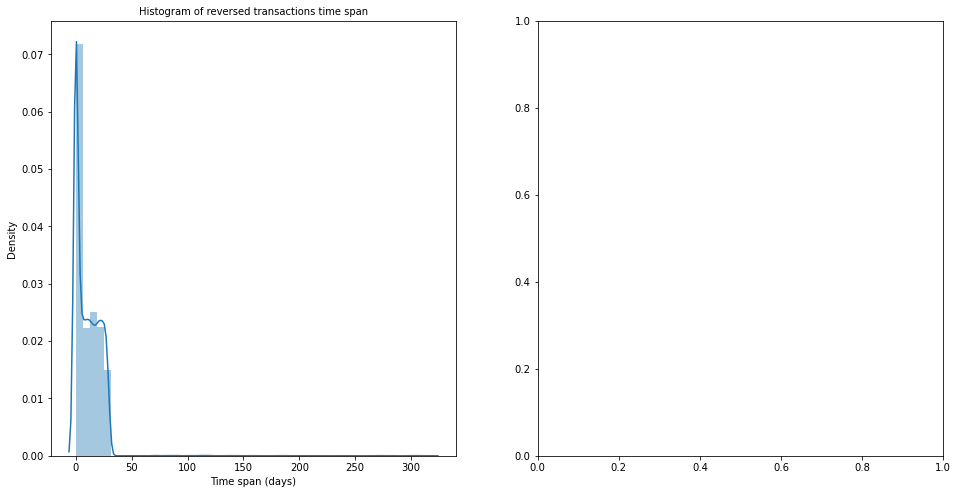

In [41]:
# Make distribution plots to visualize their time span and compare
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(reversed_trans.time_span, hist=True, kde=True, ax=ax[0])
ax[0].set_xlabel('Time span (days)')
ax[0].set_title('Histogram of reversed transactions time span', fontsize=10)

In [42]:
#From the above graphs, we can find that there're often days between multiple reversed transactions. And almost all of them happen within 50 days.
#While multi-swipe transactions often happen within few seconds. Almost all of them happen within 3 minutes

In [43]:
#Build a predictive model to determine whether a given transaction will be fraudulent or not.

In [44]:
# Make a copy of the original dataset for model building
df = data.copy()

In [45]:
# Drop columns with no records\n",
df = df.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'],axis =1)

In [46]:
#Inspect missing values columns
missingValueColumns = df.columns[df.isnull().any()].tolist()
percent_missing = df[missingValueColumns].isnull().sum() / len(df)
print(percent_missing)

acqCountry             0.005801
merchantCountryCode    0.000921
posEntryMode           0.005155
posConditionCode       0.000520
transactionType        0.000888
dtype: float64


In [47]:
df.acqCountry.value_counts()

US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64

In [48]:
df.merchantCountryCode.value_counts()

US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64

In [49]:
df.posEntryMode.value_counts()

05    315035
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64

In [50]:
df.posConditionCode.value_counts()

01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64

In [51]:
df.transactionType.value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

In [52]:
# We can see that all those 5 columns contain categorical variables and are skewed to one of a category.
#So I will use mode to impute these columns.
df['acqCountry'] = df['acqCountry'].fillna(df['acqCountry'].mode()[0])
df['merchantCountryCode'] = df['merchantCountryCode'].fillna(df['merchantCountryCode'].mode()[0])
df['posEntryMode'] = df['posEntryMode'].fillna(df['posEntryMode'].mode()[0])
df['posConditionCode'] = df['posConditionCode'].fillna(df['posConditionCode'].mode()[0])
df['transactionType'] = df['transactionType'].fillna(df['transactionType'].mode()[0])
   

In [53]:
#Feature engineering

In [54]:
# Convert cardCVV and enteredCVV to rightCVV
df['rightCVV'] = (df.cardCVV == df.enteredCVV).astype(int)
df = df.drop(['cardCVV', 'enteredCVV'], axis=1)

In [55]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV
0,737265056,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,2023-06-01,2015-03-14,2015-03-14,1803,PURCHASE,0.00,False,False,False,1
1,737265056,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,2024-02-01,2015-03-14,2015-03-14,767,PURCHASE,0.00,True,False,False,1
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.00,False,False,False,1
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,2025-08-01,2015-03-14,2015-03-14,767,PURCHASE,0.00,False,False,False,1
4,830329091,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2029-10-01,2015-08-06,2015-08-06,3143,PURCHASE,0.00,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,Lyft,US,US,90,...,2022-12-01,2012-08-23,2012-08-23,3783,PURCHASE,1095.04,False,False,False,1
786359,732852505,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,hulu.com,US,US,09,...,2023-08-01,2012-08-23,2012-08-23,3388,PURCHASE,1214.96,False,False,False,1
786360,732852505,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,Lyft,US,US,02,...,2025-08-01,2012-08-23,2012-08-23,3783,PURCHASE,1233.85,False,False,False,1
786361,732852505,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,walmart.com,US,US,09,...,2022-07-01,2012-08-23,2012-08-23,3388,PURCHASE,1283.28,False,False,False,1


In [56]:
#Convert acqCountry and merchantCountryCode to sameCountry
df['sameCountry'] = (df.acqCountry == df.merchantCountryCode).astype(int)
df = df.drop(['acqCountry', 'merchantCountryCode'], axis=1)

In [57]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,posEntryMode,posConditionCode,merchantCategoryCode,...,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV,sameCountry
0,737265056,737265056,5000.0,5000.00,2016-08-13 14:27:32,98.55,Uber,02,01,rideshare,...,2015-03-14,2015-03-14,1803,PURCHASE,0.00,False,False,False,1,1
1,737265056,737265056,5000.0,5000.00,2016-10-11 05:05:54,74.51,AMC #191138,09,01,entertainment,...,2015-03-14,2015-03-14,767,PURCHASE,0.00,True,False,False,1,1
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,09,01,mobileapps,...,2015-03-14,2015-03-14,767,PURCHASE,0.00,False,False,False,1,1
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,09,01,mobileapps,...,2015-03-14,2015-03-14,767,PURCHASE,0.00,False,False,False,1,1
4,830329091,830329091,5000.0,5000.00,2016-03-24 21:04:46,71.18,Tim Hortons #947751,02,01,fastfood,...,2015-08-06,2015-08-06,3143,PURCHASE,0.00,True,False,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22 18:44:12,119.92,Lyft,90,01,rideshare,...,2012-08-23,2012-08-23,3783,PURCHASE,1095.04,False,False,False,1,1
786359,732852505,732852505,50000.0,48785.04,2016-12-25 16:20:34,18.89,hulu.com,09,01,online_subscriptions,...,2012-08-23,2012-08-23,3388,PURCHASE,1214.96,False,False,False,1,1
786360,732852505,732852505,50000.0,48766.15,2016-12-27 15:46:24,49.43,Lyft,02,01,rideshare,...,2012-08-23,2012-08-23,3783,PURCHASE,1233.85,False,False,False,1,1
786361,732852505,732852505,50000.0,48716.72,2016-12-29 00:30:55,49.89,walmart.com,09,99,online_retail,...,2012-08-23,2012-08-23,3388,PURCHASE,1283.28,False,False,False,1,1


In [58]:
# Decide whether it's the first record of a certain customer in a certain customer
df = df.sort_values(['customerId', 'merchantName', 'transactionDateTime'])
df['firPurchase'] = df.groupby(['customerId', 'merchantName']).cumcount()
df['firPurchase'][df['firPurchase'] == 0] = 1
df['firPurchase'][df['firPurchase'] > 0] = 0

<ipython-input-58-b8b00e03db38>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['firPurchase'][df['firPurchase'] == 0] = 1
<ipython-input-58-b8b00e03db38>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['firPurchase'][df['firPurchase'] > 0] = 0


In [59]:
#Datetime Data
#The original dataset has multiple date transactionDateTime, currentExpDate, accountOpenDate and dateOfLastAddressChange. I want to convert these datetime features into time interval features, which are more informative
#For currentExpDate, I will change it to expTime, which indicates the time between the transaction date and the expiration date
#For accountOpenDate, I will change it to openTime, which indicates the time between the account open date and the transaction date
#For dateOfLastAddressChange, I will change it to changeAddTime, which indicates the time between the last of address change date and the transaction date

In [60]:
# Convert datetime to time span(days)
df['expTime'] = ((df.currentExpDate - df.transactionDateTime) / np.timedelta64(1, 'D'))
df['openTime'] = ((df.transactionDateTime - df.accountOpenDate) / np.timedelta64(1, 'D'))
df['changeAddTime'] = ((df.transactionDateTime - df.dateOfLastAddressChange) / np.timedelta64(1, 'D'))

In [61]:
#Duplicate transactions (reversed transaction and multi-swipes)
#I will add reversed transaction and multi-swipes as attributes to the dataset because 
#that pratically speaking, duplicate transactions may have higher possibilities to be fraud. So I will add dummy variables to identify whether this transaction is reversed transaction and whetehr this transaction is multi-swipes transaction.
   

In [62]:
# Subset reversed transactions in the dataset
lst_re = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime_y', 'transactionType_y']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']

In [63]:
df.loc[df.set_index(lst_or).index.isin(reversed_trans.set_index(lst_re).index) == True, 'reversed'] = 1  

In [64]:
# if not reversed transaction, reversed = 0
df.reversed = df.reversed.fillna(0)

In [65]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,posEntryMode,posConditionCode,merchantCategoryCode,...,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV,sameCountry,firPurchase,expTime,openTime,changeAddTime,reversed
541917,100088067,100088067,50000.0,49953.81,2016-04-08 19:56:36,200.12,1st BBQ,09,01,food,...,True,False,False,1,1,0,4831.169028,820.830972,820.830972,0.0
541962,100088067,100088067,50000.0,49929.31,2016-11-09 07:26:06,95.11,1st Pub,02,01,food,...,True,False,False,1,1,0,1603.690208,1035.309792,1035.309792,0.0
541920,100088067,100088067,50000.0,49996.04,2016-05-06 02:54:01,5.26,1st Sandwitch Bar #758805,02,01,food,...,True,False,False,1,1,0,6264.879155,848.120845,848.120845,0.0
541904,100088067,100088067,50000.0,49933.93,2016-02-03 04:48:54,141.60,34th BBQ #412895,09,08,food,...,True,False,False,1,1,0,5384.799375,755.200625,755.200625,0.0
541925,100088067,100088067,50000.0,50000.00,2016-06-03 18:50:55,304.15,AMC #191138,02,01,entertainment,...,True,False,False,1,1,0,5994.214641,876.785359,876.785359,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108113,999389635,999389635,5000.0,4674.08,2016-10-23 16:47:41,4.62,Play Store,05,01,mobileapps,...,False,False,False,1,1,0,6003.300220,380.699780,380.699780,0.0
108114,999389635,999389635,5000.0,4694.46,2016-11-24 00:21:46,4.62,Play Store,05,01,mobileapps,...,False,False,False,1,1,0,5971.984884,412.015116,412.015116,0.0
108115,999389635,999389635,5000.0,4714.84,2016-12-24 05:19:30,4.62,Play Store,05,01,mobileapps,...,False,False,False,1,1,0,5941.778125,442.221875,442.221875,0.0
108109,999389635,999389635,5000.0,4943.92,2016-08-04 20:27:36,42.98,oldnavy.com,09,01,online_retail,...,False,False,False,1,1,0,2521.147500,300.852500,300.852500,0.0


In [66]:
# Check the number of reversed transactions and other transactions
df.reversed.value_counts()

0.0    768604
1.0     17759
Name: reversed, dtype: int64

In [67]:
# Subset multi-swipe transactions in the dataset
lst_mul = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']

In [68]:
df.loc[df.set_index(lst_or).index.isin(multi_swipe.set_index(lst_mul).index) == True, 'multi'] = 1

In [69]:
# if not multi-swipe transaction, multi = 0
df.multi = df.multi.fillna(0)

In [70]:
#Check the number of multi-swipe transactions
df.multi.value_counts()

0.0    778913
1.0      7450
Name: multi, dtype: int64

In [71]:
#I will firstly drop some columns which will not be useful for model building.
#1. accountNumber, customerId and cardLast4Digits, which are just identifiers for each card
#2. As I explained before,  I will drop merchantName and datetime variables including: transactionDateTime, currentExpDate, accountOpenDate and dateOfLastAddressChange
#3. availableMoney, which is highly related to creditLimit and currentBalance. availableMoney = creditLimit - currentBalance

In [72]:
#Check correlation matrix to see if remaining features are correlated

In [73]:
df = df.drop(['accountNumber', 'customerId', 'cardLast4Digits', 'merchantName', 'transactionDateTime',
          'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'availableMoney'], axis=1)

In [74]:
# Create correlation matrix and select upper triangle of correlation matrix
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV,sameCountry,firPurchase,expTime,openTime,changeAddTime,reversed,multi
creditLimit,NaN,0.005581,0.653652,0.003929,0.002391,0.003108,0.001343,0.000435,NaN,0.001460,0.061550,0.062469,0.001585,0.001879
transactionAmount,NaN,NaN,0.023905,0.037361,0.001751,0.075651,0.000701,0.002096,NaN,0.002073,0.007879,0.028430,0.013546,0.007339
currentBalance,NaN,NaN,NaN,0.010529,0.001285,0.007715,0.003221,0.001113,NaN,0.004031,0.081993,0.169767,0.007321,0.005135
cardPresent,NaN,NaN,NaN,NaN,0.040393,0.043418,0.002988,0.000816,NaN,0.000097,0.020536,0.013711,0.005678,0.005805
expirationDateKeyInMatch,NaN,NaN,NaN,NaN,NaN,0.000972,0.000113,0.000419,NaN,0.000886,0.001220,0.001014,0.002953,0.000403
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,0.010006,0.000570,NaN,0.001772,0.005899,0.005933,0.001550,0.001196
rightCVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001091,NaN,0.001445,0.000047,0.001246,0.000767,0.001192
sameCountry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001238,0.000514,0.000833,0.001229,0.002300
firPurchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013492,0.003807,0.000334,0.001429


In [75]:
# Convert categorical features into dummy variables
cat = df.select_dtypes(include=['object']).columns.to_list()
df = pd.get_dummies(df, cat, drop_first=True)

In [76]:
# Convert boolean features into int variables
boo = df.select_dtypes(include=['bool']).columns.to_list()
for column in boo:
    df[column] = df[column].astype(int)
    df.reversed = df.reversed.astype(int)
    df.multi = df.multi.astype(int)

In [77]:
### 1.5. SMOTE 
#As we can see in our data analysis part, our target variabel isFraud is highly imbalanced, where there're 773946 negative class but only 12417 positive class. So I decide to use SMOTE to over-sample the dataset
#SMOTE generates the virtual training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed
   

In [78]:
# Using SMOTE to oversample the dataset
X = df.drop(['isFraud'], axis = 1)
y = df[['isFraud']]
sm = SMOTE(random_state=4)
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
print(y.isFraud.value_counts())
print(y_smote.isFraud.value_counts())

0    773946
1     12417
Name: isFraud, dtype: int64
0    773946
1    773946
Name: isFraud, dtype: int64


In [79]:
#Decision Tree
# In this the deeper the tree the more complex the model

In [80]:
# Build models with hyperparameters sets
def DT_pred(X, y):
    RSC = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions={'criterion': ['gini', 'entropy'],
           'max_depth': range(1, 100, 10),
         'max_features': ['auto', 'sqrt', 'log2']},
    cv=3, scoring='roc_auc', n_jobs=-1, verbose = True)
    # Fit RandomizedSearchCV to find best hyperparameters

    search_result = RSC.fit(X, y)
    # Build models with optimized hyperparameters
    model_DT = DecisionTreeClassifier(
    criterion=search_result.best_params_["criterion"],
    max_depth=search_result.best_params_["max_depth"],
    max_features=search_result.best_params_["max_features"])

    # Split dataset into 3 consecutive folds
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    i = 1
    for train, test in kf.split(X):  
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_DT.fit(X_train, y_train)
        train_pred = model_DT.predict(X_train)
        y_pred = model_DT.predict(X_test)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred)        
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)


In [81]:
model_DT = DT_pred(X_smote, y_smote)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fold 1 :  Training accuracy:  0.8991315285562559 Testing accuracy:  0.8921707716042204
Fold 1 :  Training precision:  0.8754356988682768 Testing precision:  0.8682581110152556
Fold 1 :  Training recall:  0.9306943165851058 Testing accuracy:  0.9246271867768082
Fold 1 :  Training auc:  0.8991308556448312 Testing auc:  0.8921721554424134
Fold 1 :  Training accuracy:  0.9183935313316433 Testing accuracy:  0.9109337085533099
Fold 1 :  Training precision:  0.8990071950161892 Testing precision:  0.8915729341953769
Fold 1 :  Training recall:  0.9426179447855735 Testing accuracy:  0.9358071075820664
Fold 1 :  Training auc:  0.9184025892574229 Testing auc:  0.9109150864786189
Fold 1 :  Training accuracy:  0.9048373529936197 Testing accuracy:  0.8977428657813336
Fold 1 :  Training precision:  0.8844579441487551 Testing precision:  0.8774469557789943
Fold 1 :  Training recall:  0.9314186296125515 Testing accuracy:  0.9244608223429015
Fo

In [82]:
joblib.dump(model_DT, "model_DT.pkl")

['model_DT.pkl']

In [83]:
def plot_performance(y_test, y_pred, y_pred_prob):
    test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # ROC Curve
    fig = plt.figure(1, figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(test_fpr, test_tpr, label="ROC (area = %0.4f)" % roc_auc_score(y_test, y_pred), color="blue", lw=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    # Precision Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', color="blue", lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision Recall Curve")
    plt.tight_layout()
    plt.show()

In [84]:
def plot_confusion(y_test, y_pred):  
    cm = confusion_matrix(y_test, y_pred)
   # Confusion Matrix
    plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(1,1,1, adjustable='box', aspect=1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    np.set_printoptions(precision=2)
    plt.show()



In [85]:
RSC = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions={'criterion': ['gini', 'entropy'],
           'max_depth': range(1, 100, 10),
         'max_features': ['auto', 'sqrt', 'log2']},
    cv=3, scoring='roc_auc', n_jobs=-1, verbose = True)
    # Fit RandomizedSearchCV to find best hyperparameters

search_result = RSC.fit(X, y)
    # Build models with optimized hyperparameters
model_DT = DecisionTreeClassifier(
    criterion=search_result.best_params_["criterion"],
    max_depth=search_result.best_params_["max_depth"],
    max_features=search_result.best_params_["max_features"])

    # Split dataset into 3 consecutive folds
kf = KFold(n_splits=3, shuffle=True, random_state=None)
i = 1
for train, test in kf.split(X):  
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_DT.fit(X_train, y_train)
        train_pred = model_DT.predict(X_train)
        y_pred = model_DT.predict(X_test)
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


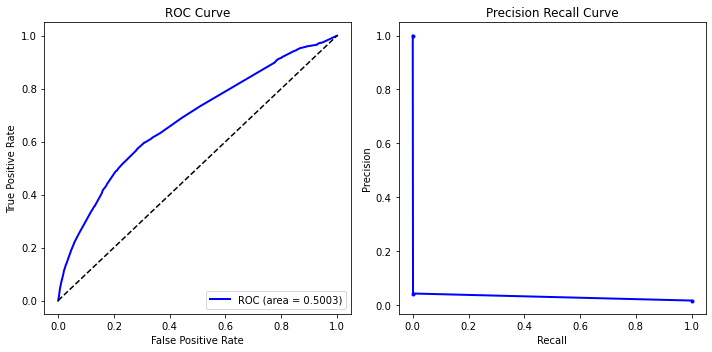

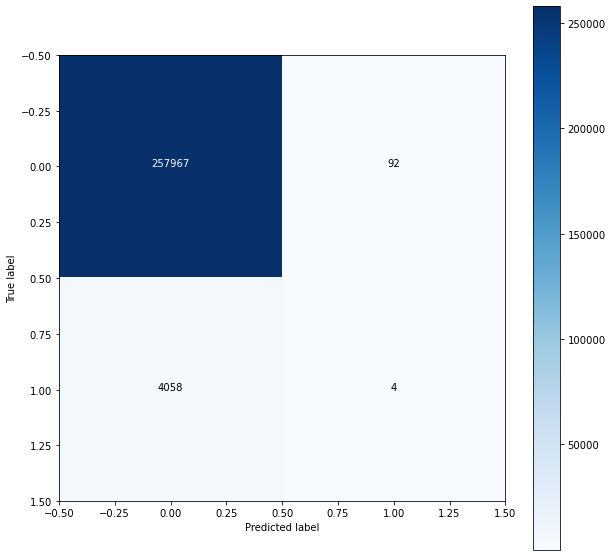

In [86]:
#Decision Tree performance
y_pred = model_DT.predict(X_test)
y_pred_prob = model_DT.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
plot_performance(y_test, y_pred, y_pred_prob)
plot_confusion(y_test, y_pred)

In [87]:
'''
Decision tree is a non-parametric supervised learning method. 
The rule for decision tree algorithm are generally in form of if-then-else statements.
The deeper the tree, the more complex the rules and fitter the model. The reason why I use decision trees is that 
it's a very interpretable model and it's very transparent.If we are going to show the workflow of our machine learning 
model to our non-technical clients, decision tree may be a very good choice. We can easily visualize our decision tree model
   
'''


"\nDecision tree is a non-parametric supervised learning method. \nThe rule for decision tree algorithm are generally in form of if-then-else statements.\nThe deeper the tree, the more complex the rules and fitter the model. The reason why I use decision trees is that \nit's a very interpretable model and it's very transparent.If we are going to show the workflow of our machine learning \nmodel to our non-technical clients, decision tree may be a very good choice. We can easily visualize our decision tree model\n   \n"

In [89]:
'''
I made 3 plots to evaluate the model that is ROC Curve, Precision-recall Curve and Confusion Matrix

-ROC Curve:
ROC Curve shows the dependency between TPR (True Positive Rate) and FPR (False Positive Rate). The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. 
It describes how good the model is at predicting the positive class when the actual outcome is positive. The false positive rate is also referred
to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.
A skilled model should have an area of 1.0 under the curve.

-Precision-Recall Curve:
Precision-Recall curve shows the trade-off between the true positive rate and the positive predictive value for a predictive model
Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value. 
Recall is the ratio of the number of true positives divided by the sum of the true positives and the false negatives.
A skilled model should also have an area of 1.0 under the curvel, which means that it has both high precision and high recall. 
   
-Confusion matrix:
Confusion matrix directly gives the number of correct and incorrect classifications made by the classifier.The left diagonal shows the number of correct predictions made for each class while the right diagonal shows the number of wrong predictions made. Upper right counts false positive case. Lower left counts false negative cases
Our random forest model also has the lowest false cases. It's false positive case is 2314 and false negative case is 1228. False positive means that the model incorrectly labels a legitimate transaction as fraudulent, and false negative means that the model mistakenly ignore a fraudulent transaction and labels it as normal.
'''
   

"\nI made 3 plots to evaluate the model that is ROC Curve, Precision-recall Curve and Confusion Matrix\n\n-ROC Curve:\nROC Curve shows the dependency between TPR (True Positive Rate) and FPR (False Positive Rate). The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. \nIt describes how good the model is at predicting the positive class when the actual outcome is positive. The false positive rate is also referred\nto as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.\nA skilled model should have an area of 1.0 under the curve.\n\n-Precision-Recall Curve:\nPrecision-Recall curve shows the trade-off between the true positive rate and the positive predictive value for a predictive model\nPrecision is a ratio of the number of true positives divided by the sum of the true positives and fal